In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def plot_boxplots(dataframe):
    """
    Plot boxplots for each column in the dataframe
    """
    columns = dataframe.columns
    fig, axes = plt.subplots(nrows=len(columns), figsize=(12, 6 * len(columns)))
    for i, column in enumerate(columns):
        ax = axes[i]
        ax.boxplot(dataframe[column])
        ax.set_title(f"Boxplot of {column}")
        ax.set_ylabel("Values")
    plt.tight_layout()
    plt.show()


In [3]:
def test_stationarity(data, target_column):
    """
    Checks the stationarity of the time series
    """
    target_series = data[target_column]
    test_name = ""
    is_stationary = None

    # Augmented Dickey-Fuller Test (ADF)
    result = sm.tsa.adfuller(target_series)
    print('ADF Test Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] < 0.05:
        is_stationary = True
        test_name = "Augmented Dickey-Fuller (ADF)"

    # KPSS Test
    if is_stationary is None:
        result = sm.tsa.kpss(target_series)
        print('KPSS Test Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:', result[3])
        if result[1] < 0.05:
            is_stationary = False
            test_name = "KPSS"

    value = "" if is_stationary else "not "
    message = f"The time series is {value}stationary according to the {test_name} test with p-value={result[1]}"
    return message

In [4]:
def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1):
    """
    Split the dataframe into train, validation, and test sets
    """
    N = dataframe.shape[0]
    Ntrain = int(tr_size * N)
    Nval = int(vl_size * N)
    Ntst = N - Ntrain - Nval

    train = dataframe[:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

In [5]:
def evaluate_time_series_forecast(serie, train, val, test):
    """
    Evaluate the time series forecast using AutoRegressive model
    """
    best_lags = None
    best_score = float('inf')
    for lags in range(1, 14):
        model = AutoReg(train, lags=lags)
        model_fit = model.fit()
        yhat = model_fit.predict(start=len(train), end=len(train) + len(val) - 1)
        mae = mean_absolute_error(val, yhat)
        mse = mean_squared_error(val, yhat)
        rmse = np.sqrt(mse)
        score = mae + mse + rmse
        if score < best_score:
            best_score = score
            best_lags = lags

    model = AutoReg(serie, lags=best_lags)
    model_fit = model.fit()
    start_idx = len(serie)
    end_idx = start_idx + 6
    forecast = model_fit.predict(start=start_idx, end=end_idx)

    fig, ax = plt.subplots(figsize=(17, 10))
    ax.plot(train.index, train, color='blue', label='Train')
    ax.plot(val.index, val, color='orange', label='Validation')
    ax.plot(test.index, test, color='green', label='Test')
    forecast_index = pd.date_range(start=test.index[-1] + pd.DateOffset(1), periods=len(forecast))
    ax.plot(forecast_index, forecast, color='red', label='Forecasted Revenue')
    ax.set_xlabel('Time')
    ax.set_ylabel('Revenue')
    ax.set_title('Existing Sales, Train & Test Data, and Forecasted Revenue')
    ax.legend()
    plt.show()

    model = AutoReg(train, lags=best_lags)
    model_fit = model.fit()
    yhat = model_fit.predict(start=len(train), end=len(train) + len(val) - 1)
    mae = mean_absolute_error(val, yhat)
    mse = mean_squared_error(val, yhat)
    rmse = np.sqrt(mse)

    data_out = [['MAE', mae],
                ['MSE', mse],
                ['RMSE', rmse]]

    return data_out

In [6]:
# Loading data
data = pd.read_csv('Marketing Raw Data.csv')



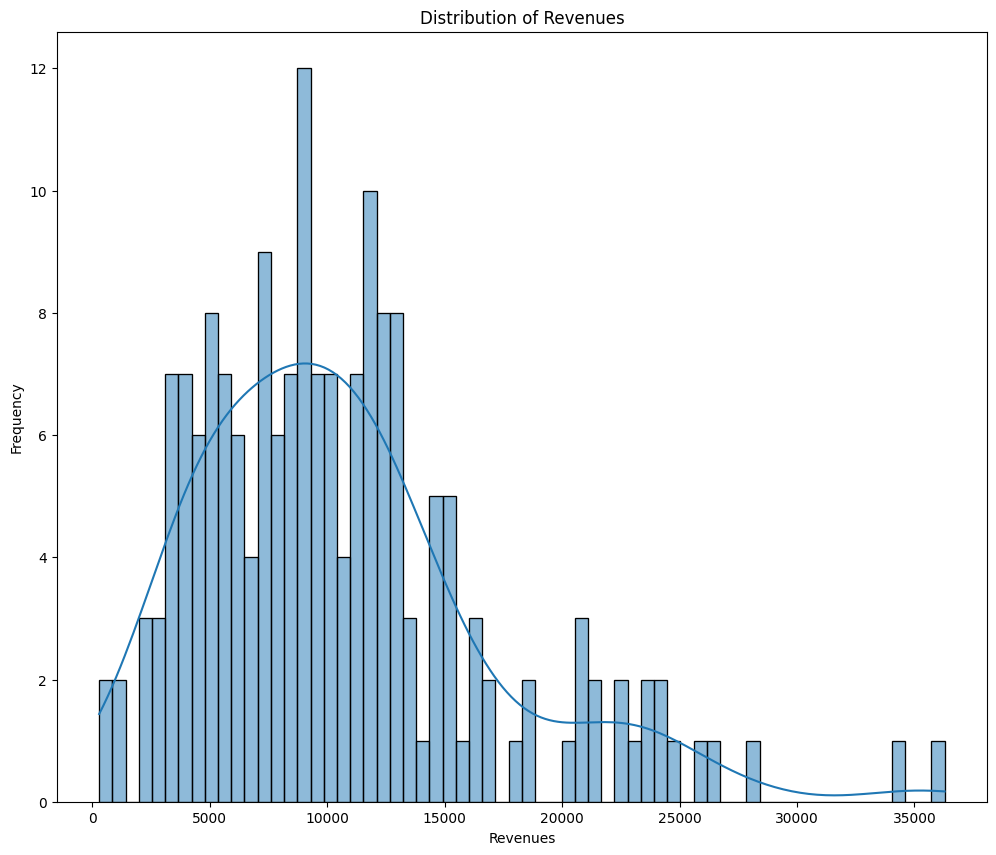

In [7]:
# Exploratory Data Analysis

# Distribution of revenues
plt.figure(figsize=(12, 10))
sns.histplot(data['Revenue'], bins=64, kde=True)
plt.xlabel('Revenues')
plt.ylabel('Frequency')
plt.title('Distribution of Revenues')
plt.show()



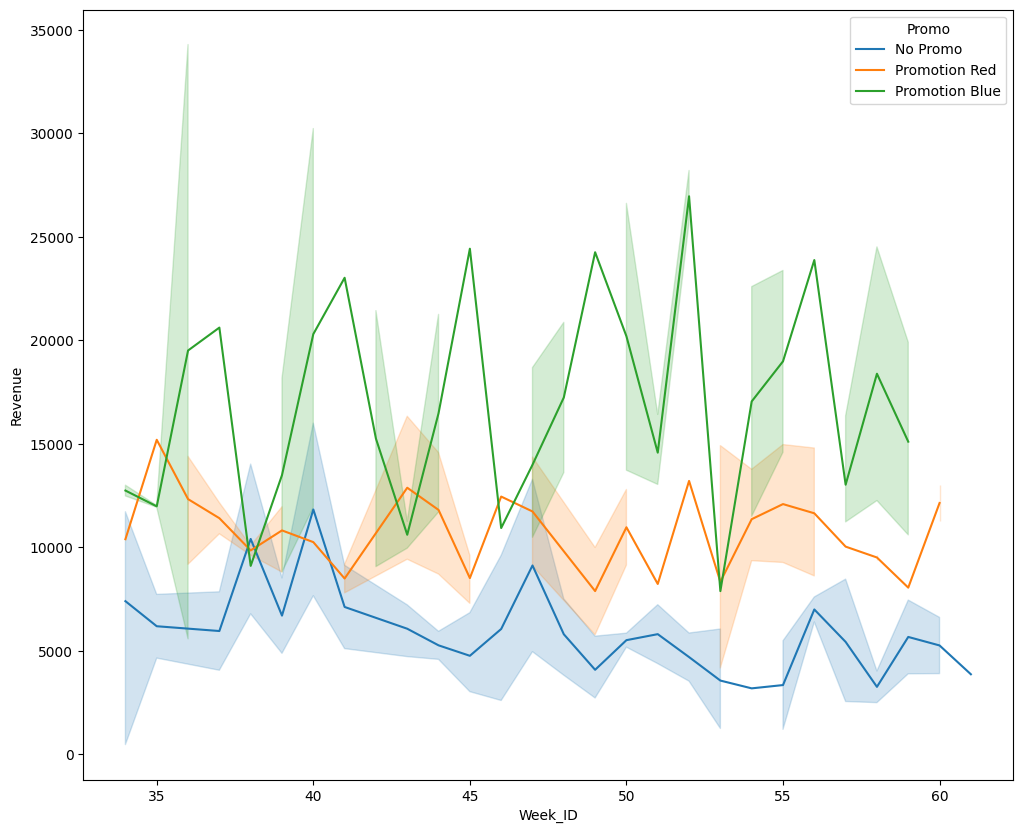

In [8]:
# Revenues by week
plt.figure(figsize=(12, 10))
sns.lineplot(x='Week_ID', y='Revenue', data=data, hue='Promo')
plt.show()


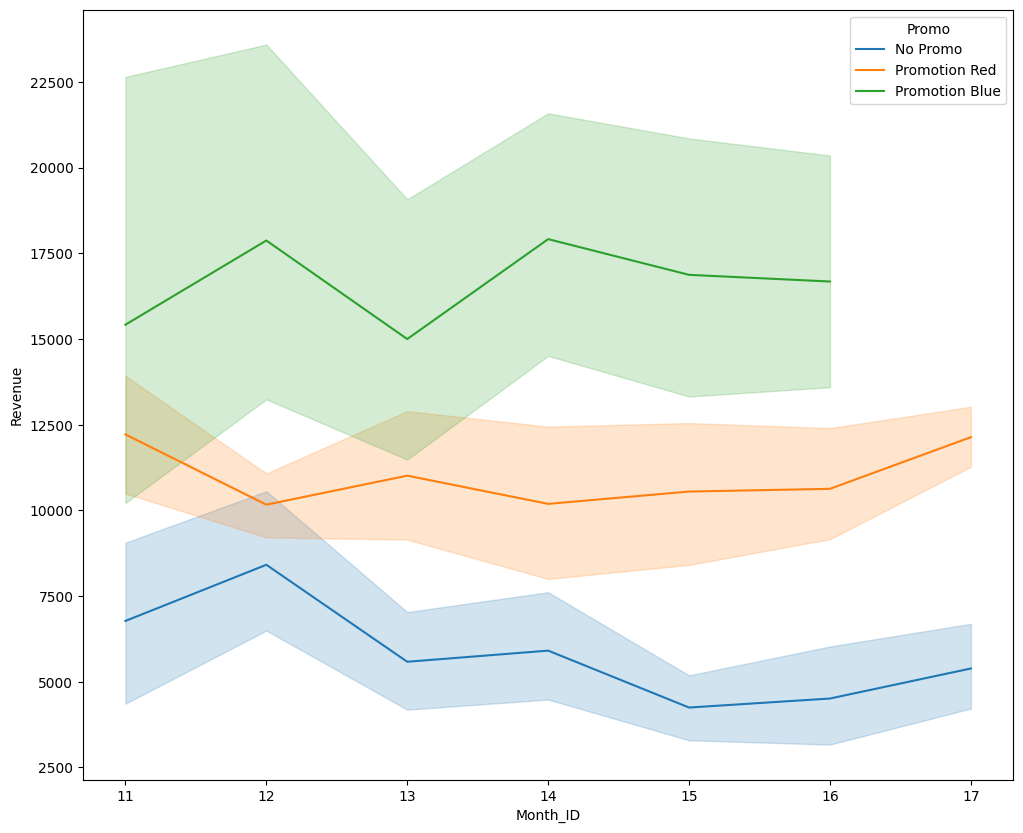

In [9]:
# Revenues by month
plt.figure(figsize=(12, 10))
sns.lineplot(x='Month_ID', y='Revenue', data=data, hue='Promo')
plt.show()

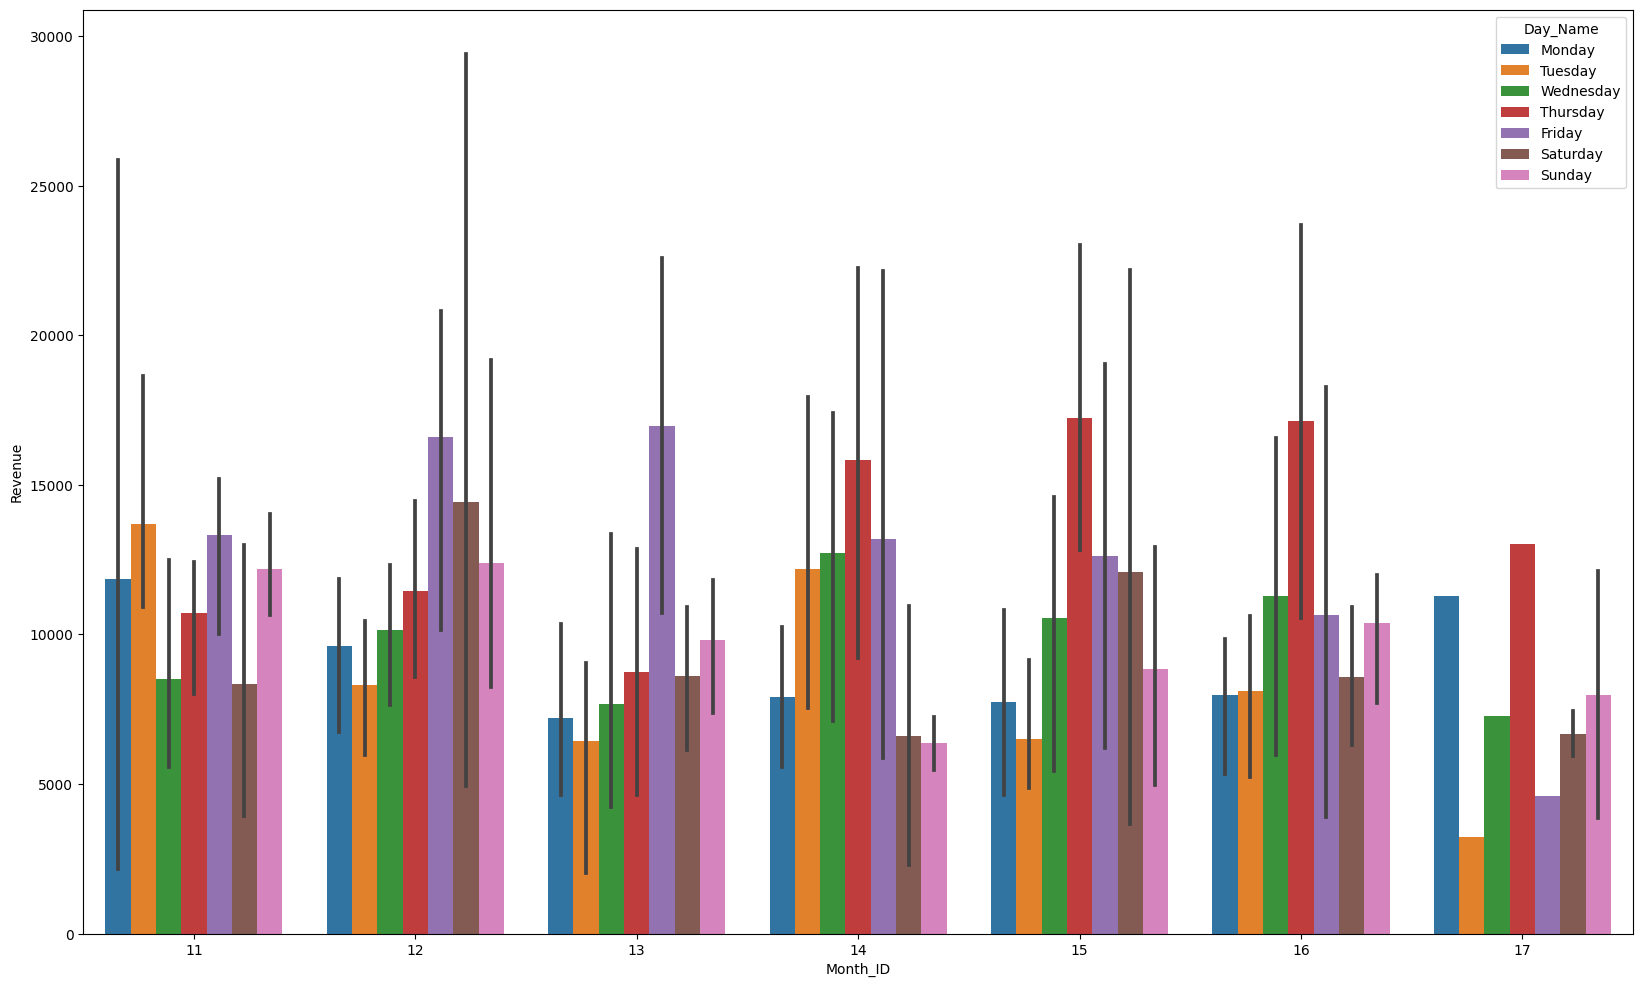

In [10]:
# Revenues by month and day
plt.figure(figsize=(20, 12))
sns.barplot(x='Month_ID', y='Revenue', data=data, hue='Day_Name')
plt.show()

<Axes: xlabel='Year'>

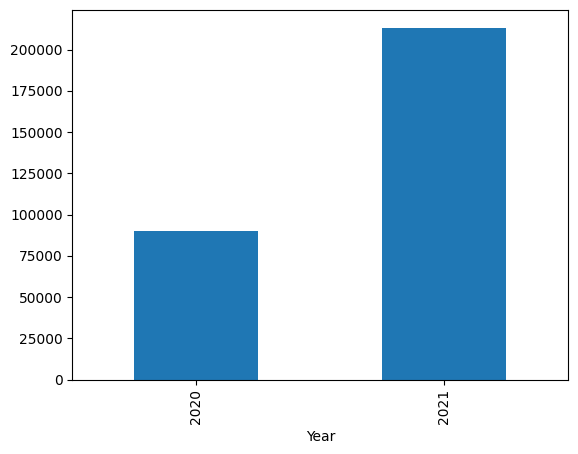

In [11]:
# Visitors
data.groupby('Week_ID').sum()['Visitors'].plot(kind="bar")
data.groupby('Month_ID').sum()['Visitors'].plot(kind="bar")
data.groupby('Year').sum()['Visitors'].plot(kind="bar")


<Axes: xlabel='Year'>

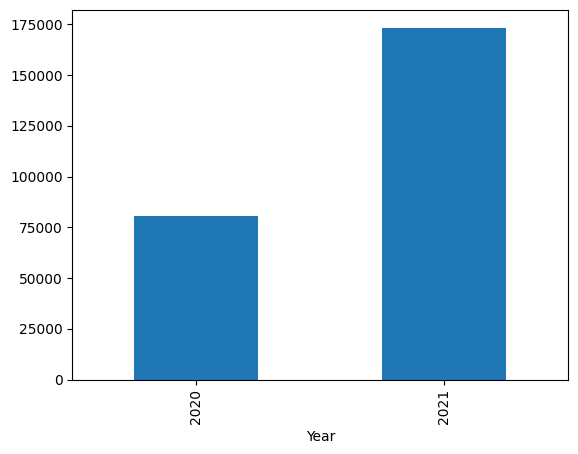

In [12]:

# Marketing expenses
data.groupby('Week_ID').sum()['Marketing Spend'].plot(kind="bar")
data.groupby('Month_ID').sum()['Marketing Spend'].plot(kind="bar")
data.groupby('Year').sum()['Marketing Spend'].plot(kind="bar")



In [13]:
# Time Series Analysis

# Set date as index
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")
data.set_index('Date', inplace=True)


In [14]:

# Divide the dataset
endogenous_cols = ['Revenue', 'Visitors', 'Marketing Spend']
exogenous_cols = ['Revenue']
endogenous_data = data[endogenous_cols]
exogenous_data = data[exogenous_cols]


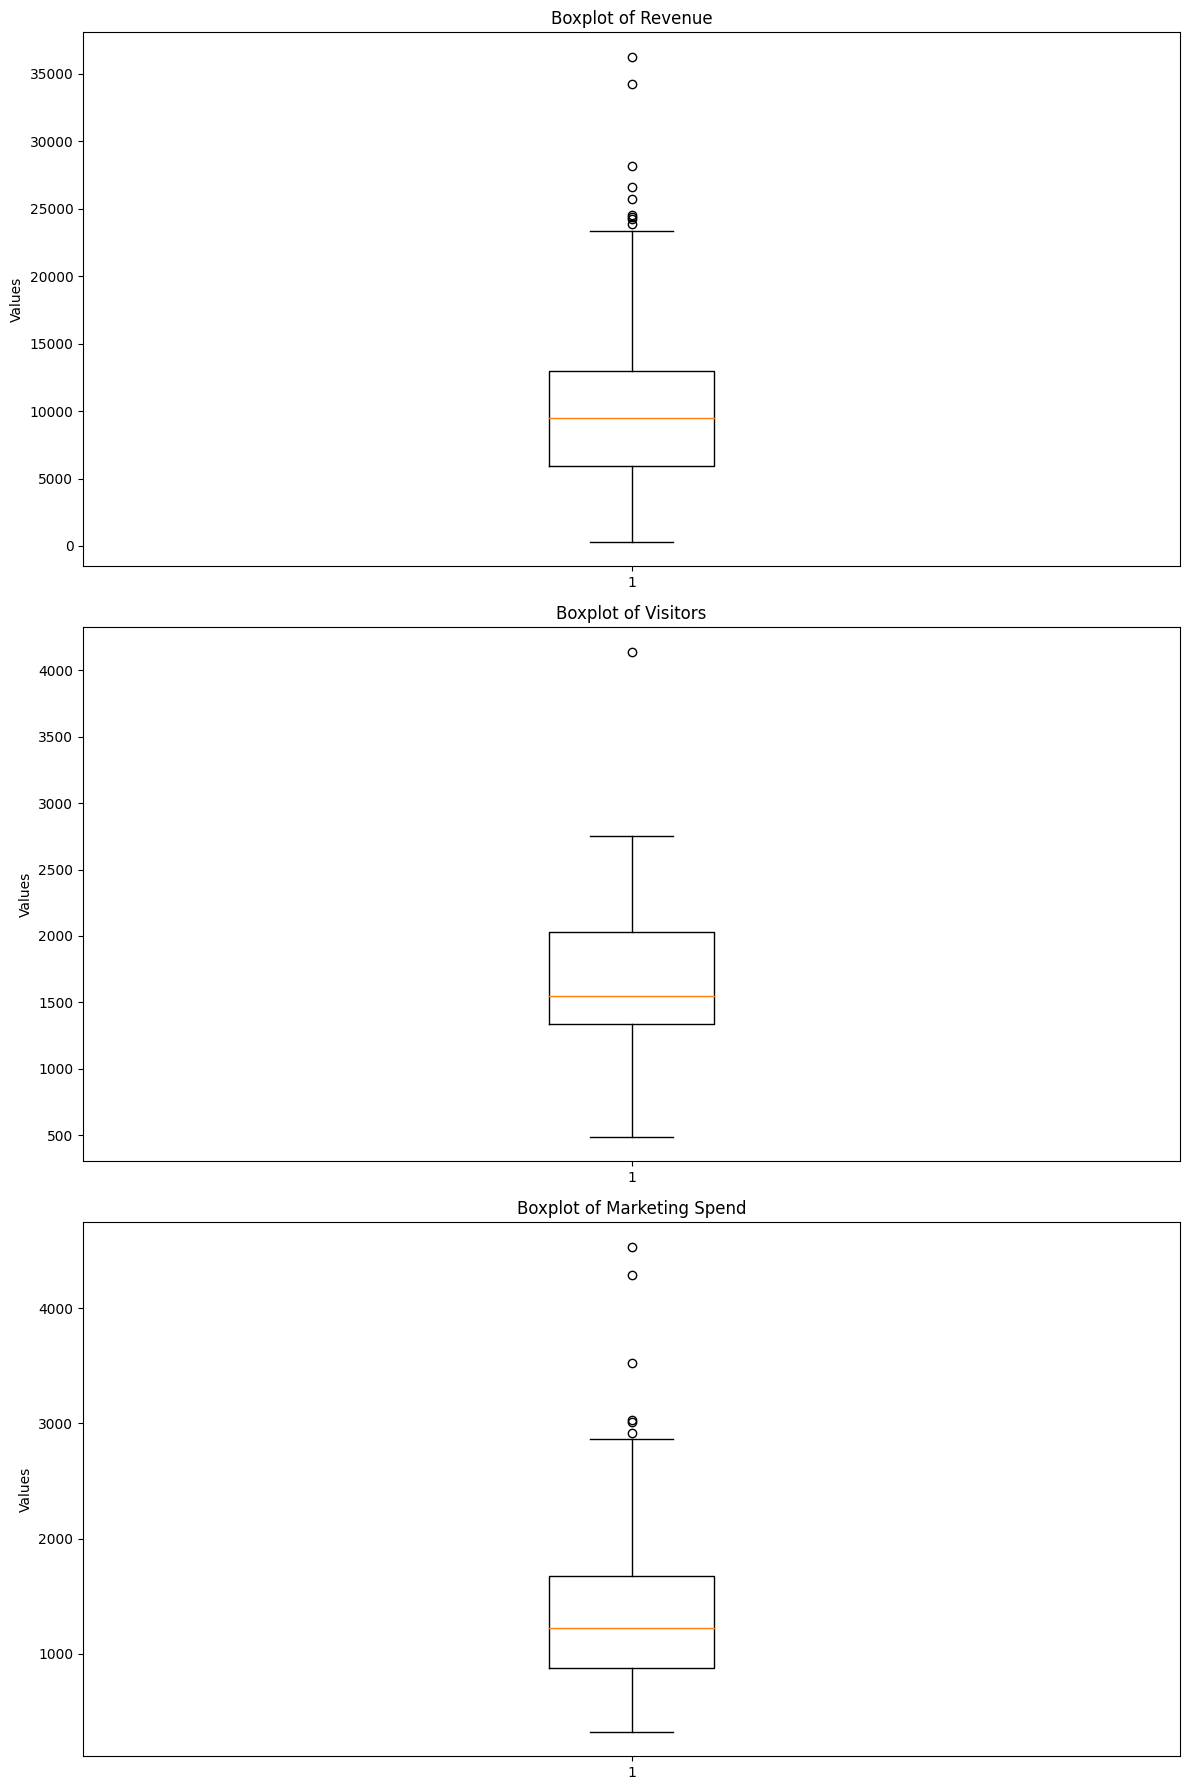

In [15]:

# Plot boxplots to check for outliers
plot_boxplots(endogenous_data)



In [16]:
# Check skewness of endogenous variables
for column in endogenous_data.columns:
    skewness = endogenous_data[column].skew()
    print(f"Skewness of column '{column}': {skewness:.4f}")



Skewness of column 'Revenue': 1.2368
Skewness of column 'Visitors': 0.7127
Skewness of column 'Marketing Spend': 1.5603


In [17]:
# Test stationarity of endogenous variable (Revenue)
stationarity_message = test_stationarity(endogenous_data, 'Revenue')
print(stationarity_message)



ADF Test Statistic: -12.208895941264121
p-value: 1.1761344552386508e-22
Critical Values: {'1%': -3.467004502498507, '5%': -2.8776444997243558, '10%': -2.575355189707274}
The time series is stationary according to the Augmented Dickey-Fuller (ADF) test with p-value=1.1761344552386508e-22


In [18]:
# Split the dataset into train, validation, and test sets
train, val, test = train_val_test_split(endogenous_data)



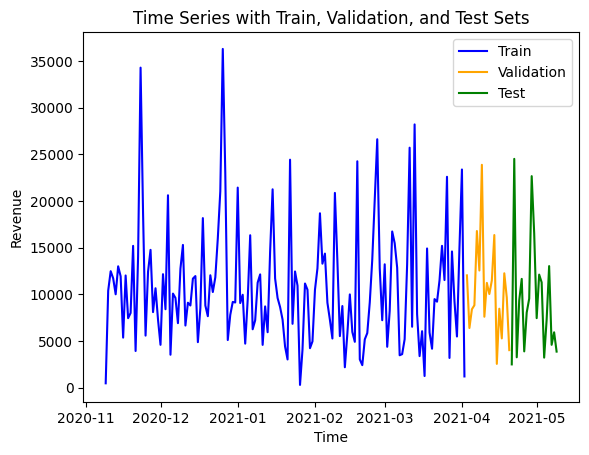

In [19]:
# Plot the time series
plt.plot(train.index, train['Revenue'], color='blue', label='Train')
plt.plot(val.index, val['Revenue'], color='orange', label='Validation')
plt.plot(test.index, test['Revenue'], color='green', label='Test')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.title('Time Series with Train, Validation, and Test Sets')
plt.legend()
plt.show()



/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set 

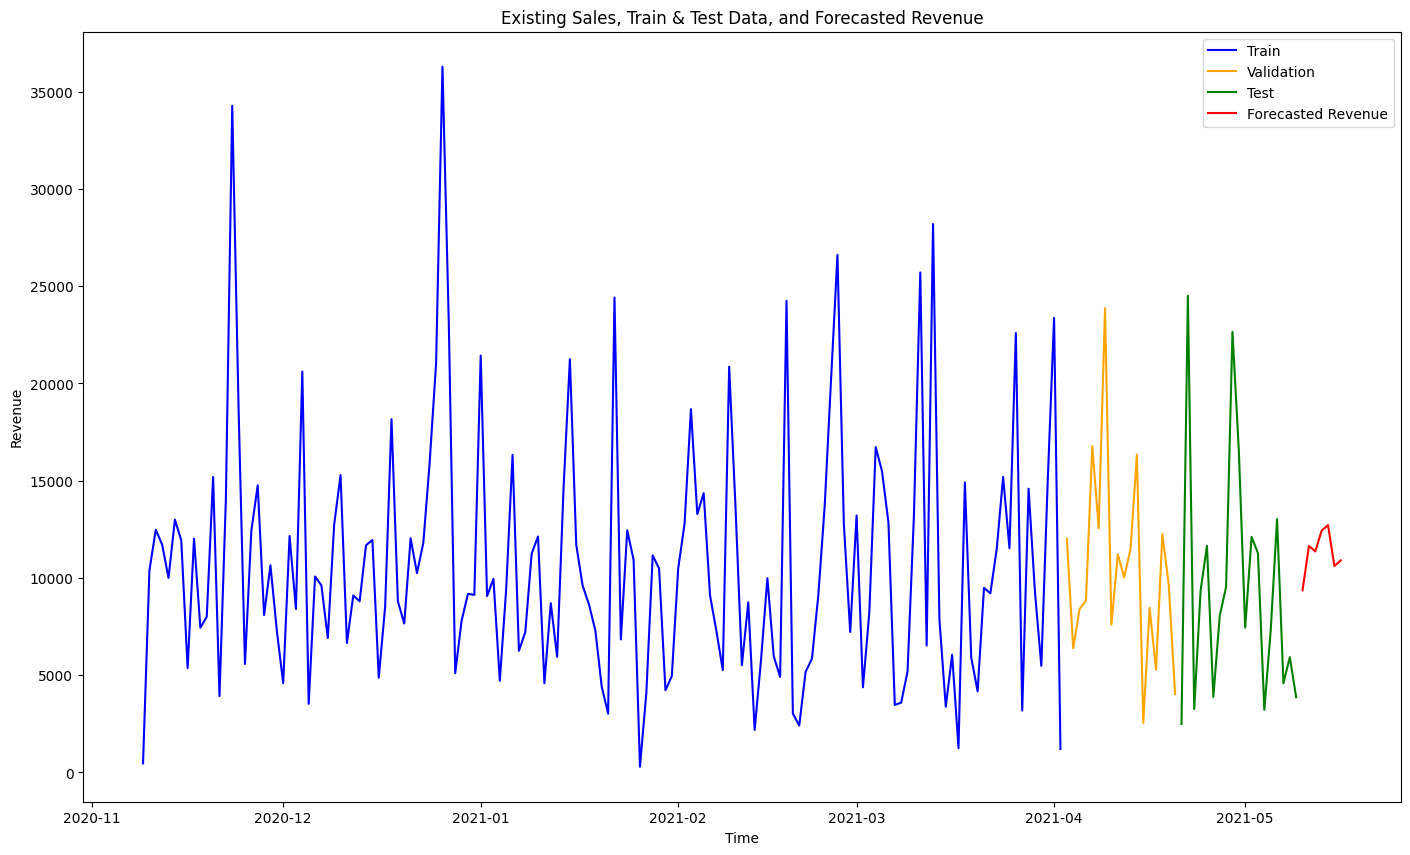

  Metric         Value
0    MAE  3.346471e+03
1    MSE  2.038282e+07
2   RMSE  4.514733e+03


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [20]:
# Evaluate time series forecast
evaluation_results = evaluate_time_series_forecast(endogenous_data['Revenue'], train['Revenue'], val['Revenue'], test['Revenue'])
evaluation_df = pd.DataFrame(evaluation_results, columns=['Metric', 'Value'])
print(evaluation_df)